# Morphological Analysis of 3D Models

This notebook demonstrates the process of morphological analysis based on 3D model. This is done in the following two steps.
1. Analysis of basic morphological characteristics such as volume and surface area of 3D models；
2. Cell density and cell distribution analysis.

### Packages

In [2]:
import os
import spateo as st
import numpy as np

### Data source

Take CNS as an example.

In [3]:
tissue = "CNS primordium"

data_folder="/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction/E8-10_b_all_anno_scsq/2_reconstruct_tissues/mesh"
pc = st.tl.tdr.read_model(filename=os.path.join(data_folder, "CNS primordium_pc_model.vtk"))
voxel = st.tl.tdr.read_model(filename=os.path.join(data_folder, "CNS primordium_voxel_model.vtk"))
########################################################################################################################
save_folder = r"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction"
save_cellbin_tdr_folder = os.path.join(save_folder, r"E8-10_b_all_anno_scsq")
save_cellbin_tdr_4_folder = os.path.join(save_cellbin_tdr_folder, r"4_morphology_3D_model")
save_cellbin_tdr_mesh_folder = os.path.join(save_cellbin_tdr_4_folder, r"mesh")
save_cellbin_tdr_image_folder = os.path.join(save_cellbin_tdr_4_folder, r"image")

for folder in [save_folder, save_cellbin_tdr_folder, save_cellbin_tdr_4_folder, save_cellbin_tdr_mesh_folder, save_cellbin_tdr_image_folder]:
    if not os.path.exists(folder):
        os.mkdir(folder)

### Analysis of basic morphological characteristics such as volume and surface area of 3D models

In [4]:
# The spatial coordinate information in this data is relative.
# In the Stereo-seq chip, the relative distance of 1 represents 0.5 microns, so to obtain the true physical distance,
# we multiply the coordinates in the original data by 0.5 / 1000. (centimeter level)
cm_pc = pc.copy()
cm_voxel = voxel.copy()

cm_pc.points = cm_pc.points * 0.5 / 1000
cm_voxel.points = cm_voxel.points * 0.5 / 1000

cm_voxel["groups"] = np.asarray([tissue] * cm_voxel.n_cells)
morphology_info = st.tl.tdr.model_morphology(model=cm_voxel, pc=cm_pc)

|-----> Length (x) of model: 0.46522;
|-----> Width (y) of model: 0.30051;
|-----> Height (z) of model: 0.15315;
|-----> Surface area of model: 0.34701;
|-----> Volume of model: 0.0035;
|-----> Volume / surface area ratio of model: 0.01009.
|-----> Cell density of model: 639142.85714.


#### Visualization

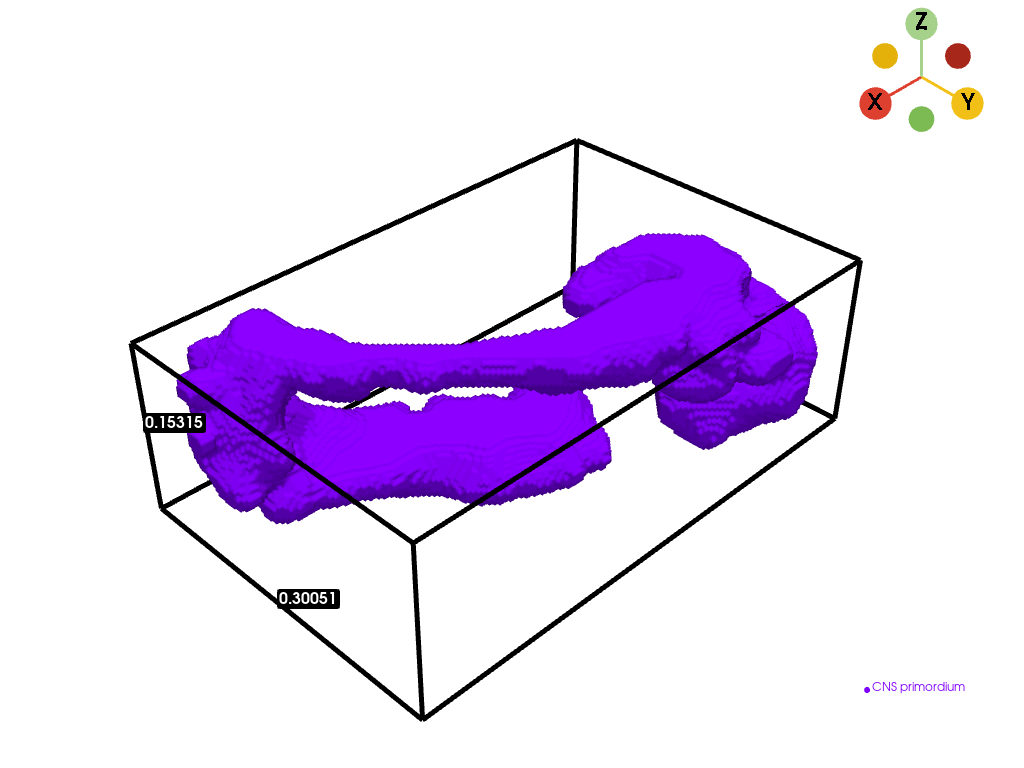

([(0.875175724703333, 0.7924538426562981, 0.7067782031468803),
  (0.234265827778373, 0.15154394573133784, 0.06586830622192008),
  (0.0, 0.0, 1.0)],
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
 

In [5]:
st.pl.three_d_plot(model=cm_voxel, key="groups", jupyter="static", off_screen=True, outline=True, outline_labels=True)
st.pl.three_d_plot(model=cm_voxel, key="groups", filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue}_morphology.tiff"),
                   jupyter=False, off_screen=True, outline=True, outline_labels=True)

### Cell density and cell distribution analysis

In [6]:
# pc kde
st.tl.tdr.pc_KDE(pc=pc, bandwidth=10, key_added="pc_kde", colormap="RdYlBu_r", alphamap=.9, inplace=True)

# interpolate
source_pc = pc.copy()
del source_pc.point_data["obs_index"], source_pc.point_data["groups"]
interpolate_voxel = st.tl.tdr.interpolate_model(model=voxel, source=source_pc, N=5, where="point_data")

#### Viusalization

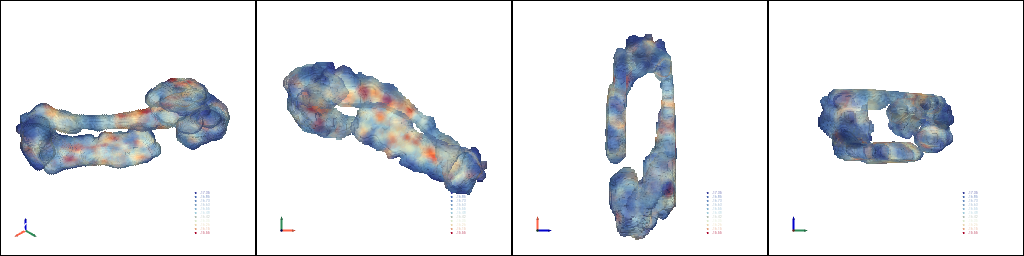

In [7]:
def visualization(model, jupyter=False, save_image=None):
    p = st.pl.create_plotter(jupyter=jupyter, off_screen=True, background="white", shape=(1, 4), window_size=(1024, 256))
    for i, cpo in enumerate(["iso", "xy", "zx", "yz"]):
        p.subplot(0, i)
        st.pl.add_model(plotter=p, model=model, key="pc_kde")
        st.pl.add_legend(plotter=p, model=model, key="pc_kde")
        p.add_axes()
        p.camera_position = cpo
    st.pl.output_plotter(p=p, filename=save_image, jupyter=jupyter)

visualization(model=interpolate_voxel, jupyter="static")
visualization(model=interpolate_voxel, jupyter=False, save_image=os.path.join(save_cellbin_tdr_image_folder, f"{tissue}_volume_kde.tiff"))

#### Slicing the model

In [8]:
slices_models = [
    st.tl.tdr.three_d_slice(model=interpolate_voxel, axis="x", n_slices=10, method="axis"),
    st.tl.tdr.three_d_slice(model=interpolate_voxel, axis="y", n_slices=10, method="axis"),
    st.tl.tdr.three_d_slice(model=interpolate_voxel, axis="z", n_slices=10, method="axis"),
    st.tl.tdr.three_d_slice(model=interpolate_voxel, method="orthogonal"),
]

#### Visualization

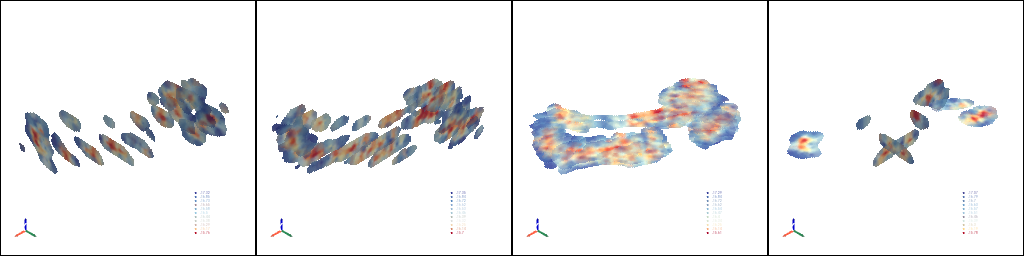

In [9]:
def visualization_slicing(sliceing_models, jupyter=False, save_image=None):
    p = st.pl.create_plotter(jupyter=jupyter, off_screen=True, background="white", shape=(1, 4), window_size=(1024, 256))
    for i, model in enumerate(sliceing_models):
        p.subplot(0, i)
        st.pl.add_model(plotter=p, model=model, key="pc_kde")
        st.pl.add_legend(plotter=p, model=model, key="pc_kde")
        p.add_axes()
        p.camera_position = "iso"
    st.pl.output_plotter(p=p, filename=save_image, jupyter=jupyter)

visualization_slicing(sliceing_models=slices_models, jupyter=True)
visualization_slicing(sliceing_models=slices_models, jupyter=False,
                      save_image=os.path.join(save_cellbin_tdr_image_folder, f"{tissue}_slicing_kde.tiff"))